In [1]:
from pcd_dataset import PointCloudDataset
from plane_detector import StructuralRANSAC
from semantic_segmentation import SemanticSegmentor
from pointnet_utils import PointnetInference
import yaml
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

In [2]:
FILE = "./data/room2.ply"

In [3]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

In [4]:
s_val = PointCloudDataset(FILE)

In [16]:
sem_seg = SemanticSegmentor(s_val, StructuralRANSAC, PointnetInference, config)

/Users/dmytroivanov/projects/o3d/pcd_dataset.py:351: RuntimeWarning: divide by zero encountered in matmul
  points_xyz = points_xyz @ R_yup_to_zup.T
/Users/dmytroivanov/projects/o3d/pcd_dataset.py:351: RuntimeWarning: overflow encountered in matmul
  points_xyz = points_xyz @ R_yup_to_zup.T
/Users/dmytroivanov/projects/o3d/pcd_dataset.py:351: RuntimeWarning: invalid value encountered in matmul
  points_xyz = points_xyz @ R_yup_to_zup.T


In [17]:
# sem_seg.visualize_pcd()

In [18]:
sem_seg.ransac_segment()

Starting structural segmentation...
Detecting floor and ceiling...
  Floor found: 69534 points
  Ceiling found: 64863 points
Segmentation complete in 2.37 seconds
Found: 2 structural elements
  floor: 1
  ceiling: 1
Remaining unsegmented points: 292592


In [19]:
sem_seg.ransac_segmentor.visualize_segments()

PointCloud with 426989 points.

In [20]:
# Project to 2D
points_2d = sem_seg.points[:, :2]

In [21]:
ind = sem_seg.ransac_segmentor.segments["ceiling"]["indices"]
ceiling_points_2d = points_2d[ind]

/var/folders/j4/yzpk21j93c5bl_mjst9qb4mc0000gn/T/ipykernel_19964/114049448.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


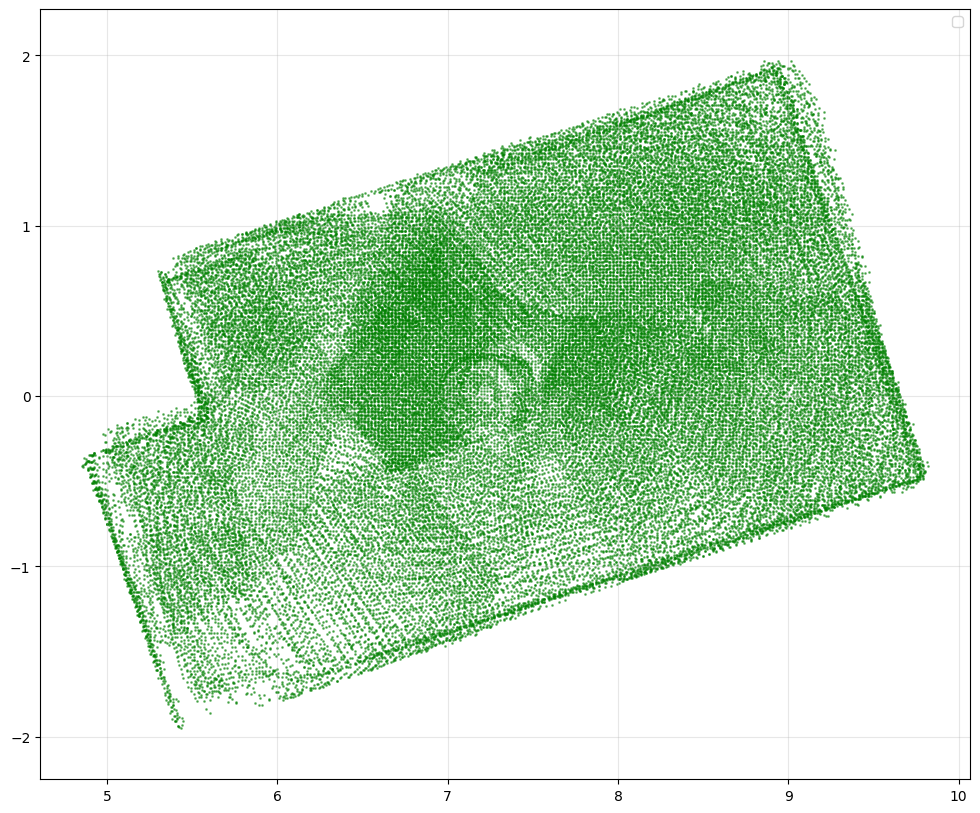

In [22]:
plt.figure(figsize=(12, 10))
plt.scatter(ceiling_points_2d[:, 0], ceiling_points_2d[:, 1], c='green', s=1,  alpha=0.5)
plt.axis('equal')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [26]:
import shapely
from shapely import MultiPoint, Polygon

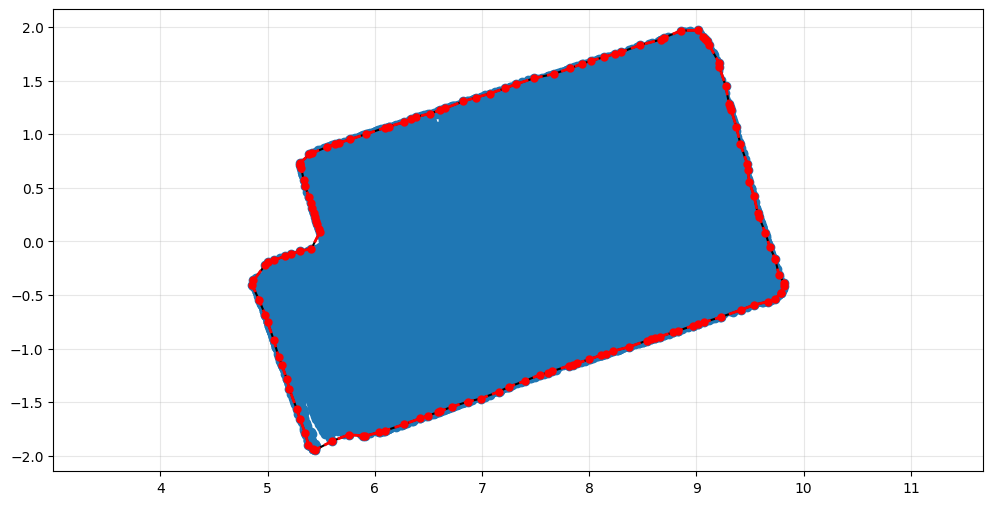

In [27]:
multi_point = MultiPoint(ceiling_points_2d)
concave = shapely.concave_hull(multi_point, ratio=0.07)

plt.figure(figsize=(12, 6))
plt.plot(ceiling_points_2d[:, 0], ceiling_points_2d[:, 1], 'o')

if concave.geom_type == 'Polygon':
    # get boundary coordinates
    x, y = concave.exterior.xy
    coords = np.array(list(zip(x, y)))
    for i in range(len(coords) - 1):
        plt.plot([coords[i, 0], coords[i+1, 0]], 
                [coords[i, 1], coords[i+1, 1]], 'k-')
    plt.plot(x, y, 'r--', lw=2, marker='o', markersize=5)

plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.show()

In [28]:
room_size = max(ceiling_points_2d[:, 0].max() - ceiling_points_2d[:, 0].min(),
                ceiling_points_2d[:, 1].max() - ceiling_points_2d[:, 1].min())
recommended_tolerance = room_size * 0.02  # 2% of room size

In [29]:
recommended_tolerance

np.float64(0.09926148)

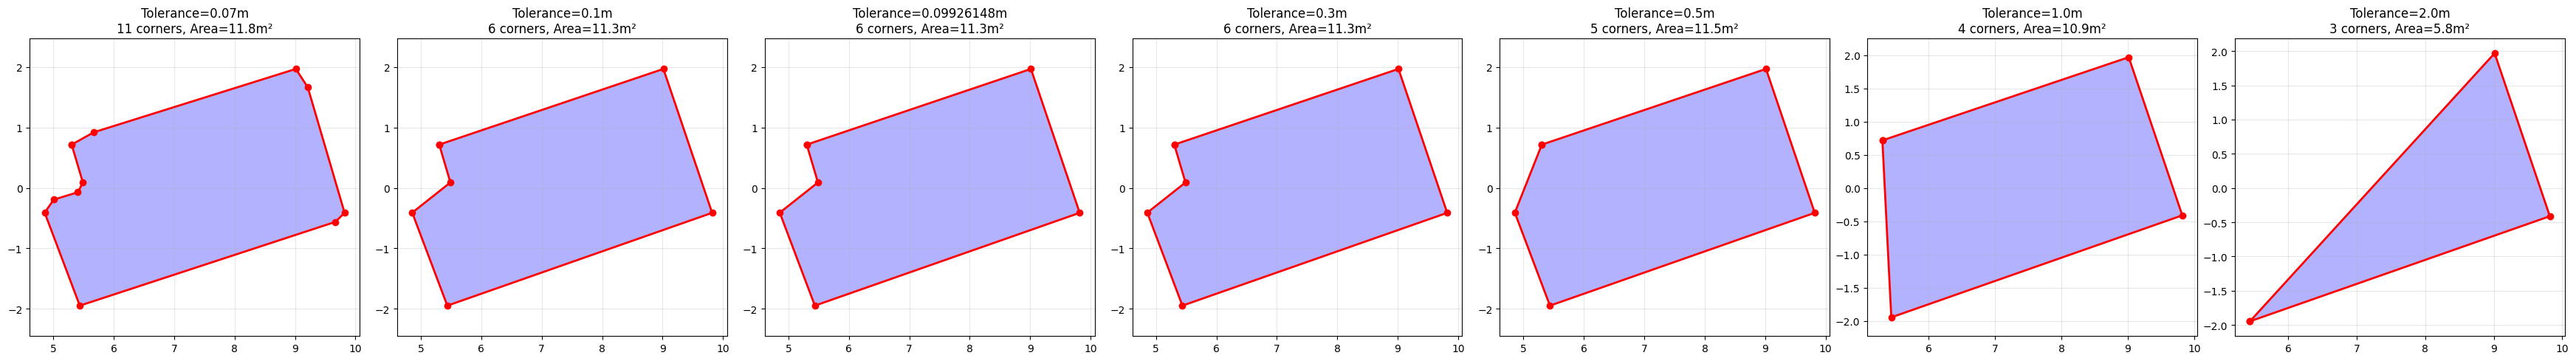

In [33]:
tolerances = [0.07, 0.1, recommended_tolerance, 0.3, 0.5, 1.0, 2.0]

fig, axes = plt.subplots(1, len(tolerances), figsize=(5*len(tolerances), 5))

for idx, tolerance in enumerate(tolerances):
    ax = axes[idx]
    
    # mimplify
    simplified = concave.simplify(tolerance, preserve_topology=True)
    
    x, y = simplified.exterior.xy
    ax.fill(x, y, alpha=0.3, fc='blue')
    ax.plot(x, y, 'r-', linewidth=2)
    ax.plot(x, y, 'ro', markersize=6)
    
    corners = len(simplified.exterior.coords) - 1
    area = simplified.area
    
    ax.set_title(f'Tolerance={tolerance}m\n{corners} corners, Area={area:.1f}m²')
    ax.axis('equal')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [75]:
room_size = max(floor_points_2d[:, 0].max() - floor_points_2d[:, 0].min(),
                floor_points_2d[:, 1].max() - floor_points_2d[:, 1].min())
recommended_tolerance = room_size * 0.02  # 2% of room size

In [76]:
simplified = concave.simplify(recommended_tolerance, preserve_topology=True)
corners = list(simplified.exterior.coords[:-1])

In [77]:
dimensions = []
for i in range(len(corners)):
    p1 = np.array(corners[i])
    p2 = np.array(corners[(i + 1) % len(corners)])
    length = np.linalg.norm(p2 - p1)
    dimensions.append(length)

In [78]:
print(f"Number of walls: {len(dimensions)}")
print(f"Wall lengths: {[f'{d:.2f}m' for d in dimensions]}")
print(f"Total perimeter: {sum(dimensions):.2f}m")
print(f"Room area: {simplified.area:.2f}m²")

Number of walls: 18
Wall lengths: ['1.63m', '0.41m', '0.54m', '0.47m', '5.76m', '0.47m', '0.49m', '3.77m', '0.50m', '3.58m', '0.75m', '1.44m', '0.55m', '0.59m', '1.76m', '0.46m', '1.00m', '3.99m']
Total perimeter: 28.15m
Room area: 42.85m²


In [34]:
import numpy as np
from scipy.spatial import Delaunay
from shapely.geometry import MultiLineString, Polygon
from shapely.ops import polygonize, unary_union

def alpha_shape(points, alpha):
    """
    Computes the alpha shape (concave hull) of a set of points.
    """
    if len(points) < 4:
        # For small point sets, the convex hull is often the only meaningful shape
        return Polygon(points).convex_hull

    # Perform Delaunay triangulation
    tri = Delaunay(points)
    triangles = points[tri.simplices]

    # Calculate edge lengths and filter based on alpha
    a = ((triangles[:,0,0] - triangles[:,1,0])**2 + (triangles[:,0,1] - triangles[:,1,1])**2)**0.5
    b = ((triangles[:,1,0] - triangles[:,2,0])**2 + (triangles[:,1,1] - triangles[:,2,1])**2)**0.5
    c = ((triangles[:,2,0] - triangles[:,0,0])**2 + (triangles[:,2,1] - triangles[:,0,1])**2)**0.5
    
    # Calculate circumradius of each triangle
    s = (a + b + c) / 2.0
    area = (s * (s - a) * (s - b) * (s - c))**0.5
    circumradius = (a * b * c) / (4.0 * area)

    # Filter edges based on circumradius and alpha
    edges = []
    for i, t in enumerate(triangles):
        if circumradius[i] < alpha:
            edges.append(((t[0,0], t[0,1]), (t[1,0], t[1,1])))
            edges.append(((t[1,0], t[1,1]), (t[2,0], t[2,1])))
            edges.append(((t[2,0], t[2,1]), (t[0,0], t[0,1])))

    # Create a MultiLineString from valid edges and polygonize
    m = MultiLineString(edges)
    triangles = list(polygonize(m))
    
    # Union the resulting polygons to form the concave hull
    return unary_union(triangles)

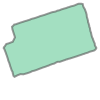

In [54]:
alpha_shape(ceiling_points_2d, 0.2)

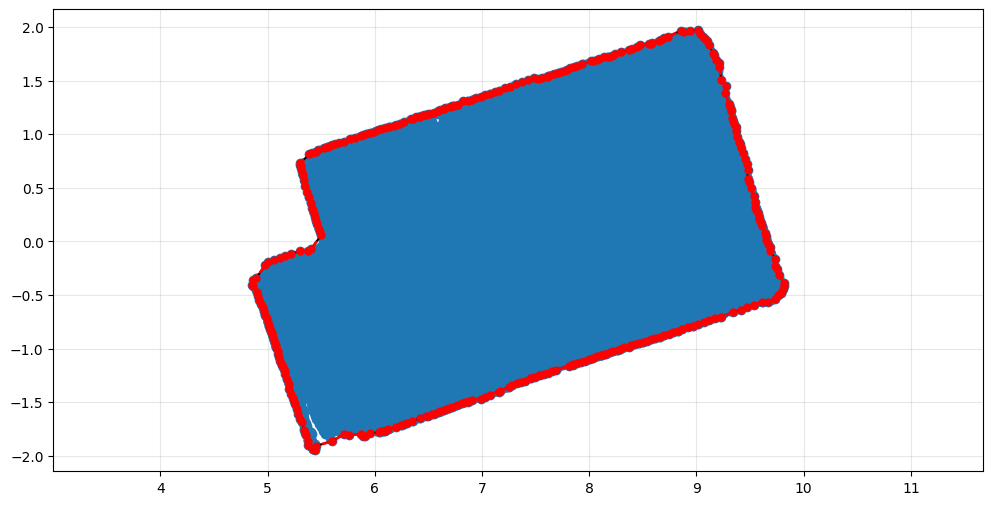

In [35]:
plt.figure(figsize=(12, 6))
plt.plot(ceiling_points_2d[:, 0], ceiling_points_2d[:, 1], 'o')

# Get alpha shape
alpha_hull = alpha_shape(ceiling_points_2d, alpha=0.1)

if alpha_hull.geom_type == 'Polygon':
    x, y = alpha_hull.exterior.xy
    coords = np.array(list(zip(x, y)))
    
    # Plot edges
    for i in range(len(coords) - 1):
        plt.plot([coords[i, 0], coords[i+1, 0]], 
                [coords[i, 1], coords[i+1, 1]], 'k-')
    
    # Plot vertices
    plt.plot(x, y, 'r--', lw=2, marker='o', markersize=5)

plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.show()

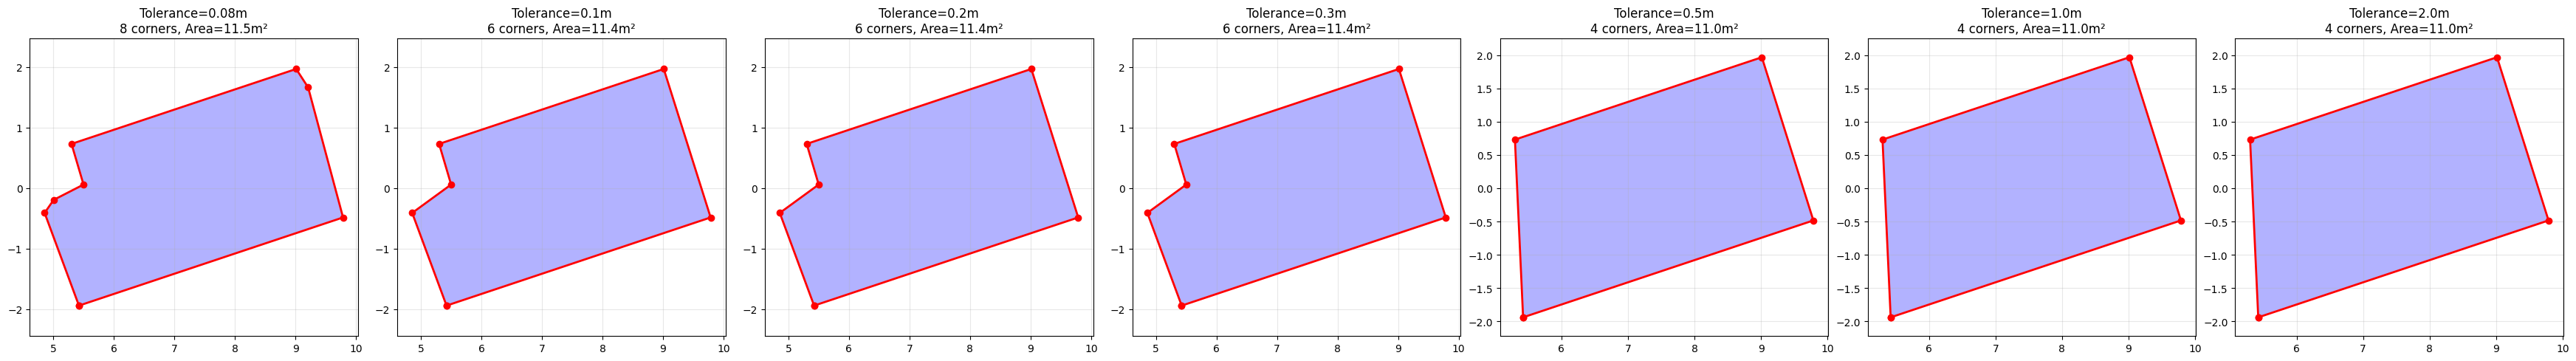

In [36]:
tolerances = [0.08, 0.1, 0.2, 0.3, 0.5, 1.0, 2.0]

fig, axes = plt.subplots(1, len(tolerances), figsize=(5*len(tolerances), 5))

for idx, tolerance in enumerate(tolerances):
    ax = axes[idx]
    
    # mimplify
    simplified = alpha_hull.simplify(tolerance, preserve_topology=True)
    
    x, y = simplified.exterior.xy
    ax.fill(x, y, alpha=0.3, fc='blue')
    ax.plot(x, y, 'r-', linewidth=2)
    ax.plot(x, y, 'ro', markersize=6)
    
    corners = len(simplified.exterior.coords) - 1
    area = simplified.area
    
    ax.set_title(f'Tolerance={tolerance}m\n{corners} corners, Area={area:.1f}m²')
    ax.axis('equal')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [66]:
simplified = alpha_hull.simplify(0.08, preserve_topology=True)
corners = len(simplified.exterior.coords) - 1

In [67]:
import matplotlib.patches as mpatches
def format_dimension(length_meters):
    """Convert meters to feet and inches"""
    total_inches = length_meters * 39.3701
    feet = int(total_inches // 12)
    inches = int(total_inches % 12)
    return f"{feet}' {inches}\""


def blueprint_style_floorplan(corners):
    """Create blueprint-style floorplan"""
    
    # # Extract boundary
    # floor_2d = floor_points[:, :2]
    # multi_point = MultiPoint(floor_2d)
    # hull = concave_hull(multi_point, ratio=ratio)
    # simplified = hull.simplify(tolerance, preserve_topology=True)
    
    corners = np.array(list(simplified.exterior.coords[:-1]))
    
    # Create figure
    fig, ax = plt.subplots(figsize=(16, 12), dpi=150)
    ax.set_facecolor('#4169E1')  # Blueprint blue
    ax.grid(True, color='#5A7FCC', linewidth=0.5, alpha=0.5)
    
    # Draw walls
    wall_thickness = 0.15
    
    for i in range(len(corners)):
        p1 = corners[i]
        p2 = corners[(i + 1) % len(corners)]
        
        # Wall direction and perpendicular
        vec = p2 - p1
        vec_norm = vec / np.linalg.norm(vec)
        perp = np.array([-vec_norm[1], vec_norm[0]])
        
        # Wall rectangle
        offset = perp * (wall_thickness / 2)
        wall_rect = np.array([
            p1 - offset, p1 + offset,
            p2 + offset, p2 - offset
        ])
        
        poly = mpatches.Polygon(wall_rect, 
                               facecolor='white', 
                               edgecolor='white',
                               linewidth=2)
        ax.add_patch(poly)
        
        # Dimension line
        length = np.linalg.norm(vec)
        midpoint = (p1 + p2) / 2
        
        # Place dimension line outside wall
        dim_offset = perp * 0.6
        dim_start = p1 + dim_offset
        dim_end = p2 + dim_offset
        dim_mid = midpoint + dim_offset
        
        # Draw dimension line
        ax.plot([dim_start[0], dim_end[0]], 
               [dim_start[1], dim_end[1]],
               'w-', linewidth=2, alpha=0.9)
        
        # Draw tick marks
        tick_size = 0.15
        tick = perp * tick_size
        ax.plot([dim_start[0]-tick[0], dim_start[0]+tick[0]],
               [dim_start[1]-tick[1], dim_start[1]+tick[1]], 'w-', lw=2)
        ax.plot([dim_end[0]-tick[0], dim_end[0]+tick[0]],
               [dim_end[1]-tick[1], dim_end[1]+tick[1]], 'w-', lw=2)
        
        # Dimension text
        text_offset = perp * 0.9
        text_pos = midpoint + text_offset
        
        # Calculate rotation angle
        angle = np.arctan2(vec[1], vec[0]) * 180 / np.pi
        if abs(angle) > 90:
            angle += 180
        
        # Format and display
        dim_text = format_dimension(length)
        ax.text(text_pos[0], text_pos[1], dim_text,
               fontsize=12, fontweight='bold', color='white',
               ha='center', va='center', rotation=angle,
               bbox=dict(boxstyle='round,pad=0.4',
                        facecolor='#4169E1',
                        edgecolor='white', linewidth=1.5))
    
    # Room area label
    centroid = simplified.centroid
    area_sqft = simplified.area * 10.764
    
    ax.text(centroid.x, centroid.y,
           f"Room\n{int(area_sqft)} sq.ft",
           fontsize=18, fontweight='bold', color='yellow',
           ha='center', va='center',
           bbox=dict(boxstyle='round,pad=0.7',
                    facecolor='#4169E1',
                    edgecolor='yellow', linewidth=2.5))
    
    # Styling
    ax.set_aspect('equal')
    ax.tick_params(colors='white')
    for spine in ax.spines.values():
        spine.set_color('white')
    
    # Margins
    bounds = simplified.bounds
    margin = 1.5
    ax.set_xlim(bounds[0] - margin, bounds[2] + margin)
    ax.set_ylim(bounds[1] - margin, bounds[3] + margin)
    
    plt.tight_layout()
    return fig, ax

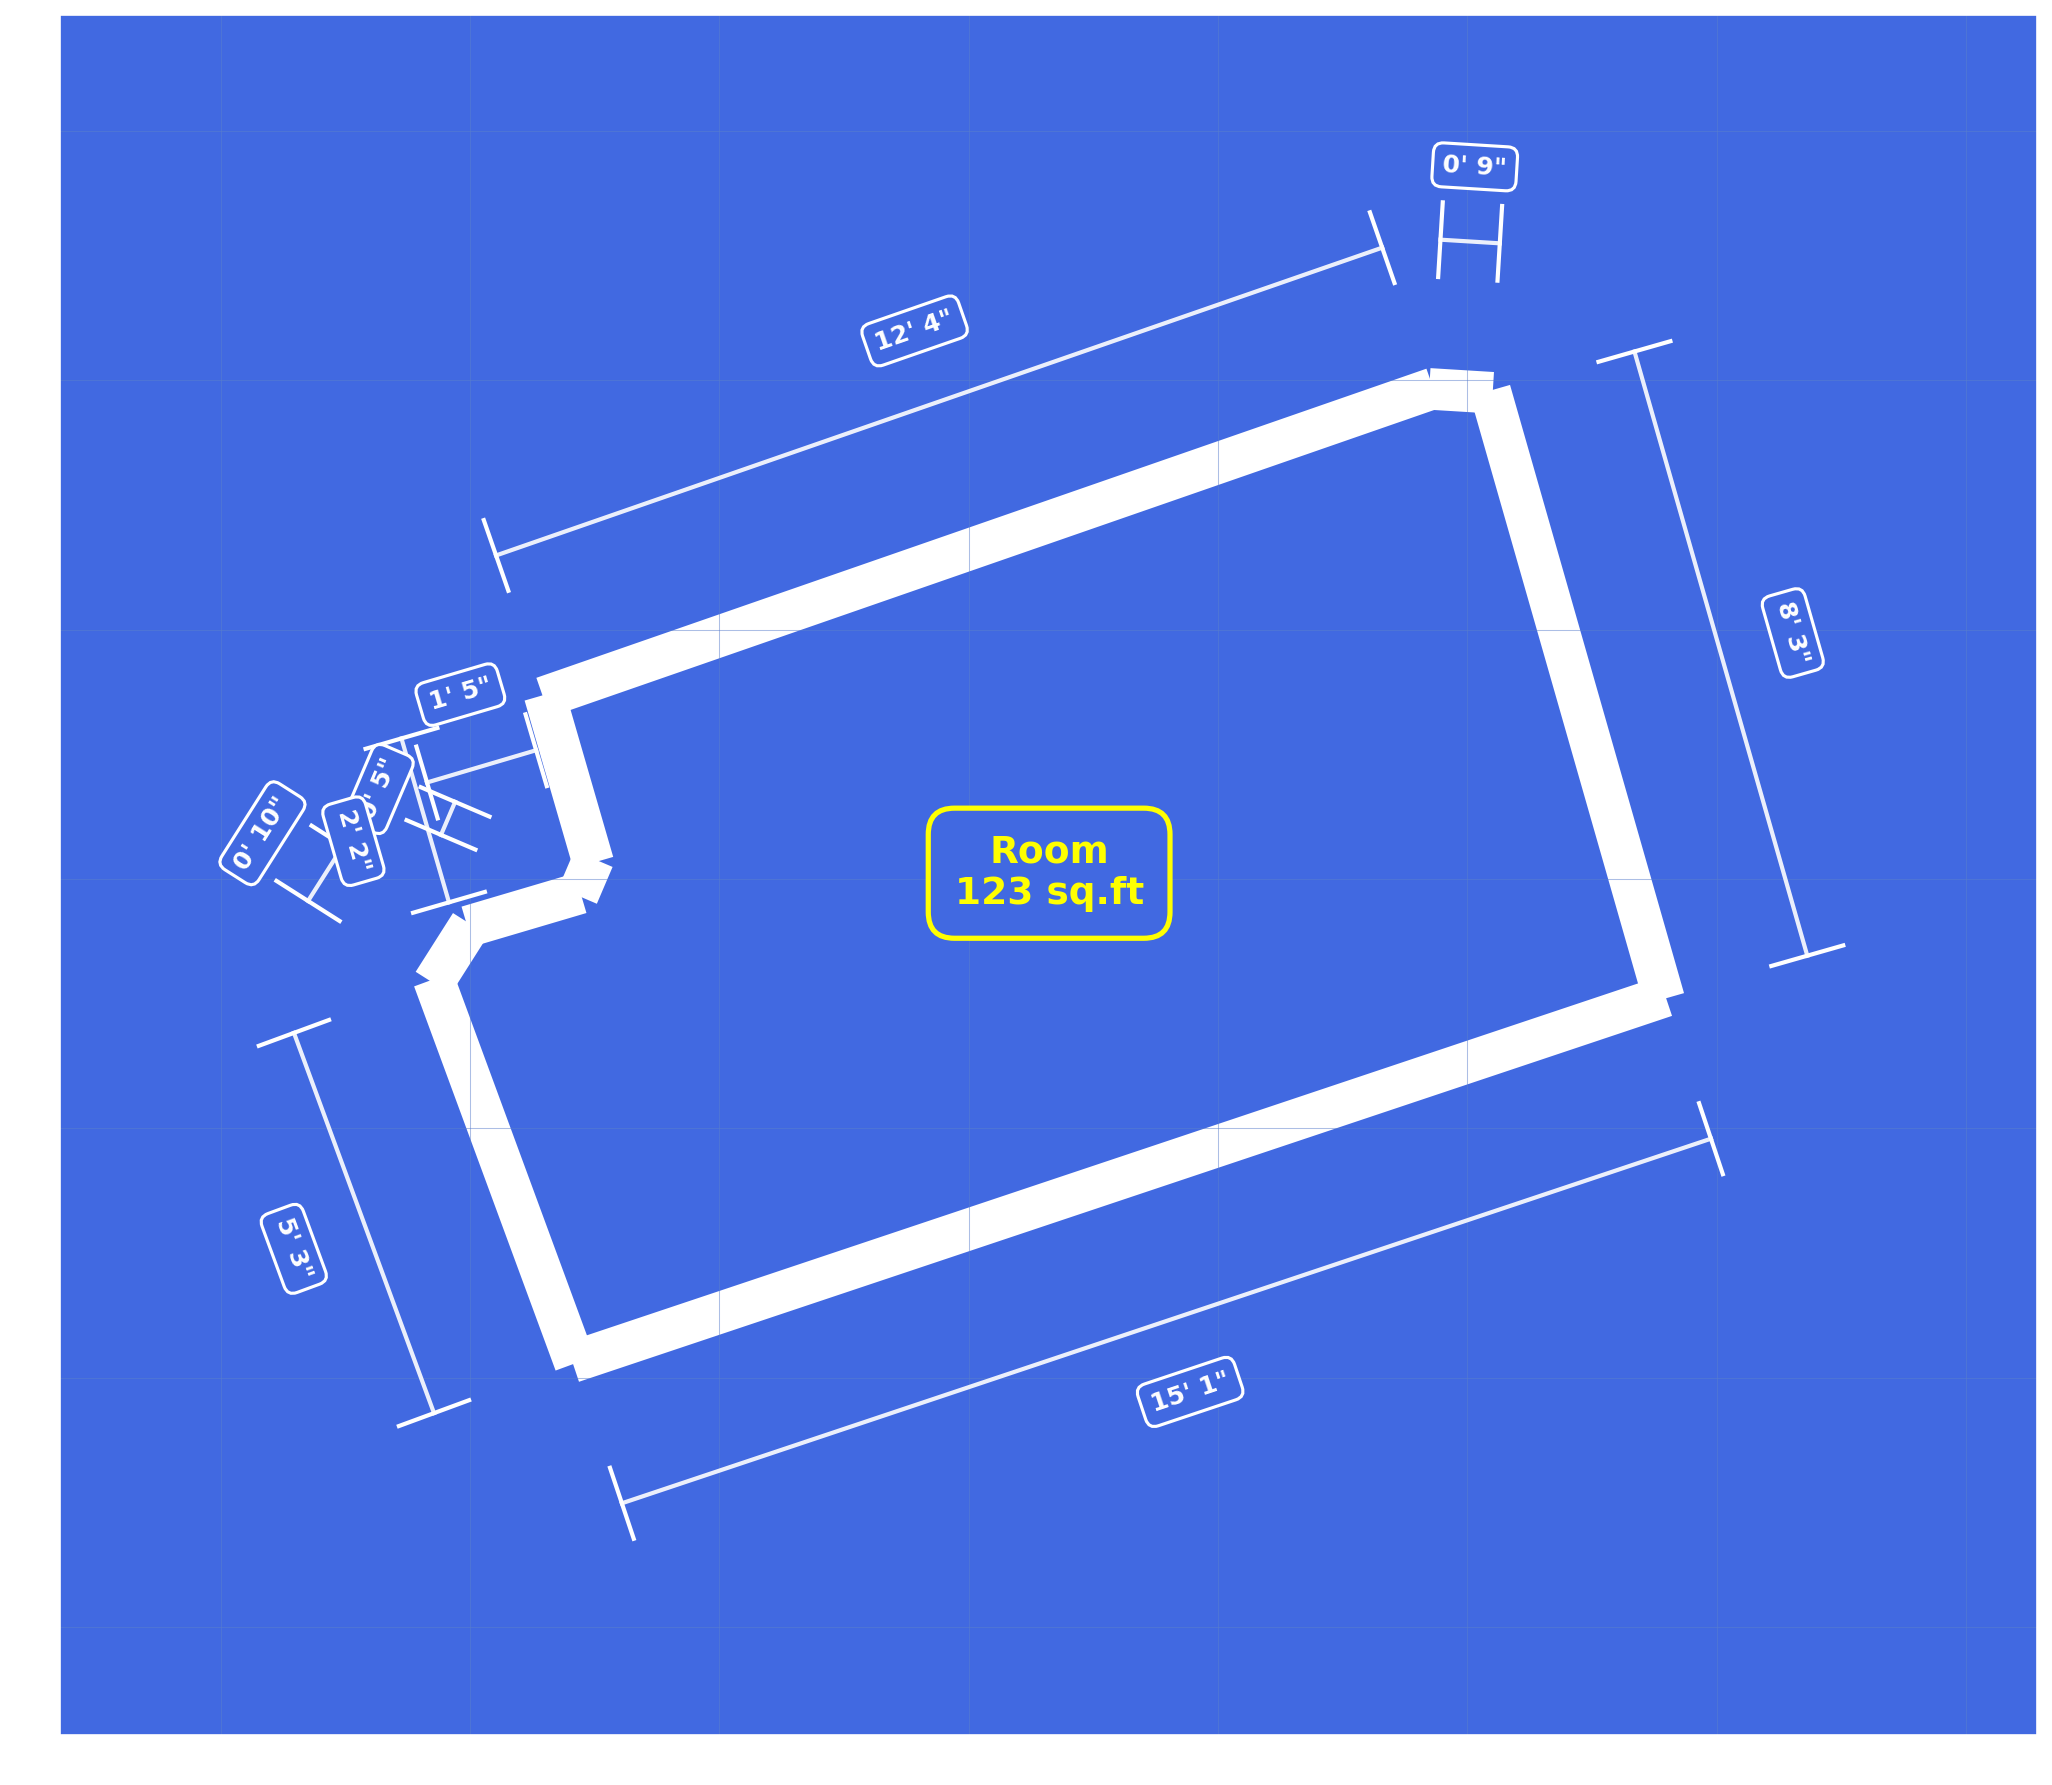

In [68]:
# Create blueprint
fig, ax = blueprint_style_floorplan(corners)
plt.savefig('professional_blueprint.png', dpi=300, facecolor='#4169E1')
plt.show()

### BY WALL

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label as nd_label
from scipy.signal import find_peaks

In [85]:
def step1_detect_ceiling_peaks(points, show_top_n=10):
    """
    STEP 1: Analyze height distribution and identify ceiling peaks
    
    Returns peaks so you can manually select which ones to use
    """
    
    print(f"\n{'='*70}")
    print(f"STEP 1: DETECT CEILING PEAKS")
    print(f"{'='*70}")
    
    z_coords = points[:, 2]
    
    # Create histogram
    bin_size = 0.02
    z_min, z_max = z_coords.min(), z_coords.max()
    bins = np.arange(z_min, z_max + bin_size, bin_size)
    hist, bin_edges = np.histogram(z_coords, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Find all peaks
    peaks, properties = find_peaks(hist, 
                                   prominence=0.02 * hist.max(),
                                   distance=5)
    
    # Sort by height (highest first)
    peak_heights = bin_centers[peaks]
    peak_counts = hist[peaks]
    sorted_indices = np.argsort(peak_heights)[::-1]
    
    print(f"Found {len(peaks)} peaks")
    print(f"\nTop {show_top_n} peaks by height:")
    print(f"{'ID':<5} {'Height (m)':<12} {'Points':<12} {'Type':<15}")
    print(f"{'─'*50}")
    
    for i, idx in enumerate(sorted_indices[:show_top_n]):
        h = peak_heights[idx]
        count = peak_counts[idx]
        
        # Classify peak
        if h > 0.5:
            peak_type = "CEILING ✓"
        elif h < -0.5:
            peak_type = "FLOOR"
        else:
            peak_type = "MID-HEIGHT"
        
        print(f"{i:<5} {h:<12.3f} {count:<12,} {peak_type:<15}")
    
    # Plot
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.bar(bin_centers, hist, width=bin_size*0.8, alpha=0.7, color='lightblue', edgecolor='black')
    ax.plot(bin_centers[peaks], hist[peaks], 'r*', markersize=12, label='All peaks')
    
    # Highlight top peaks
    for i, idx in enumerate(sorted_indices[:show_top_n]):
        h = peak_heights[idx]
        c = peak_counts[idx]
        ax.annotate(f'{i}: {h:.2f}m', 
                   xy=(h, c), xytext=(h, c + hist.max()*0.05),
                   ha='center', fontsize=9, fontweight='bold',
                   arrowprops=dict(arrowstyle='->', color='red', lw=1.5))
    
    ax.set_xlabel('Height (m)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Point count', fontsize=12, fontweight='bold')
    ax.set_title('Height Distribution - Select Ceiling Peak IDs', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Return data for manual selection
    result = {
        'peak_heights': peak_heights,
        'peak_counts': peak_counts,
        'sorted_indices': sorted_indices,
        'z_coords': z_coords,
        'points': points
    }
    
    print(f"\n✓ Inspect the plot and choose ceiling peak IDs")
    print(f"  Example: If peaks 0 and 1 are ceilings, use: [0, 1]")
    
    return result


STEP 1: DETECT CEILING PEAKS
Found 5 peaks

Top 10 peaks by height:
ID    Height (m)   Points       Type           
──────────────────────────────────────────────────
0     1.428        16,345       CEILING ✓      
1     0.108        2,343        MID-HEIGHT     
2     -0.472       3,914        MID-HEIGHT     
3     -0.772       2,557        FLOOR          
4     -1.232       15,935       FLOOR          


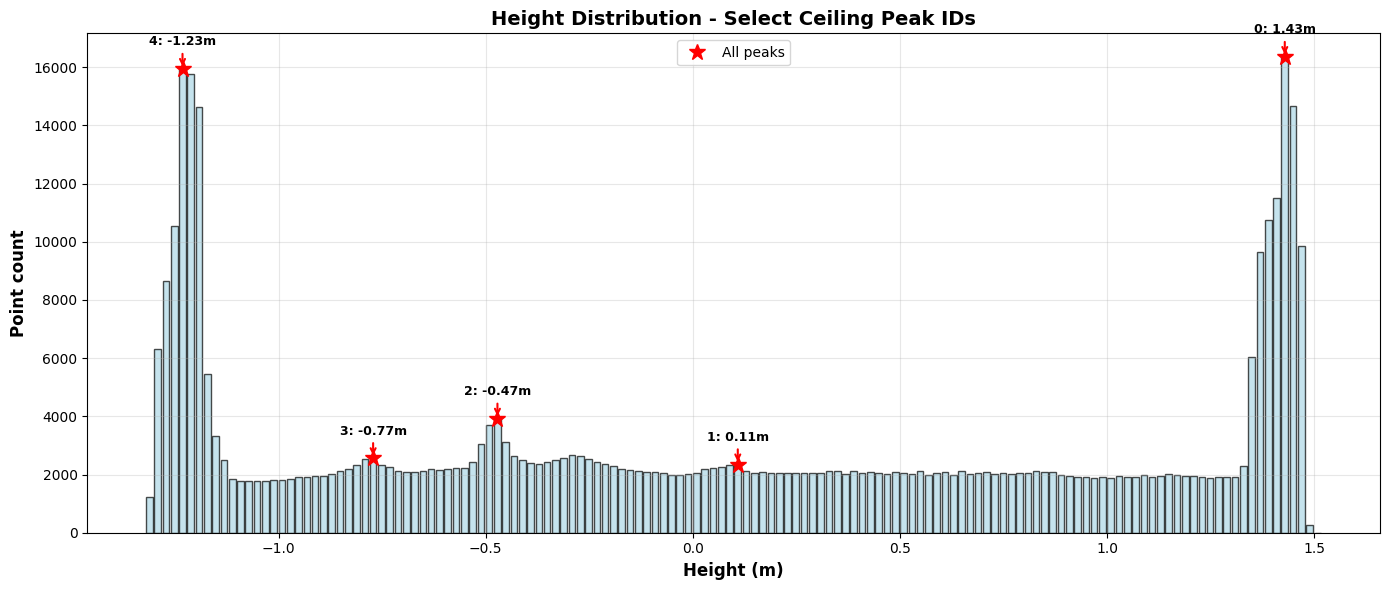


✓ Inspect the plot and choose ceiling peak IDs
  Example: If peaks 0 and 1 are ceilings, use: [0, 1]


In [86]:
step1_result = step1_detect_ceiling_peaks(points, show_top_n=10)

In [87]:
def step2_extract_ceiling_levels(step1_result, selected_peak_ids, thickness=0.10):
    """
    STEP 2: Extract ceiling points for selected peak IDs
    
    Parameters:
    -----------
    step1_result : dict
        Output from step1_detect_ceiling_peaks
    selected_peak_ids : list of int
        Which peak IDs to use as ceilings (e.g., [0, 1])
    thickness : float
        Thickness around each peak (meters)
    """
    
    print(f"\n{'='*70}")
    print(f"STEP 2: EXTRACT CEILING LEVELS")
    print(f"{'='*70}")
    
    peak_heights = step1_result['peak_heights']
    sorted_indices = step1_result['sorted_indices']
    z_coords = step1_result['z_coords']
    points = step1_result['points']
    
    ceiling_levels = []
    
    for peak_id in selected_peak_ids:
        if peak_id >= len(sorted_indices):
            print(f"⚠️  Peak ID {peak_id} out of range!")
            continue
        
        idx = sorted_indices[peak_id]
        height = peak_heights[idx]
        
        # Extract points at this height
        mask = np.abs(z_coords - height) < thickness
        level_points = points[mask]
        
        ceiling_levels.append({
            'height': height,
            'points': level_points,
            'level_id': peak_id
        })
        
        print(f"✓ Ceiling level {peak_id}: {height:.3f}m with {len(level_points):,} points")
    
    # Visualize
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(ceiling_levels)))
    
    # Top view
    for i, level in enumerate(ceiling_levels):
        pts = level['points']
        ax1.scatter(pts[:, 0], pts[:, 1], c=[colors[i]], s=1, alpha=0.7,
                   label=f"Level {level['level_id']} ({level['height']:.2f}m)")
    
    ax1.set_aspect('equal')
    ax1.set_xlabel('X (m)', fontsize=12)
    ax1.set_ylabel('Y (m)', fontsize=12)
    ax1.set_title('Ceiling Levels (Top View)', fontsize=14, fontweight='bold')
    ax1.legend(markerscale=5)
    ax1.grid(True, alpha=0.3)
    
    # 3D view
    ax2 = plt.subplot(122, projection='3d')
    for i, level in enumerate(ceiling_levels):
        pts = level['points']
        if len(pts) > 10000:
            indices = np.random.choice(len(pts), 10000, replace=False)
            pts = pts[indices]
        ax2.scatter(pts[:, 0], pts[:, 1], pts[:, 2],
                   c=[colors[i]], s=1, alpha=0.6)
    
    ax2.set_xlabel('X (m)')
    ax2.set_ylabel('Y (m)')
    ax2.set_zlabel('Z (m)')
    ax2.set_title('Ceiling Levels (3D)', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Extracted {len(ceiling_levels)} ceiling level(s)")
    
    return ceiling_levels


STEP 2: EXTRACT CEILING LEVELS
✓ Ceiling level 0: 1.428m with 80,351 points


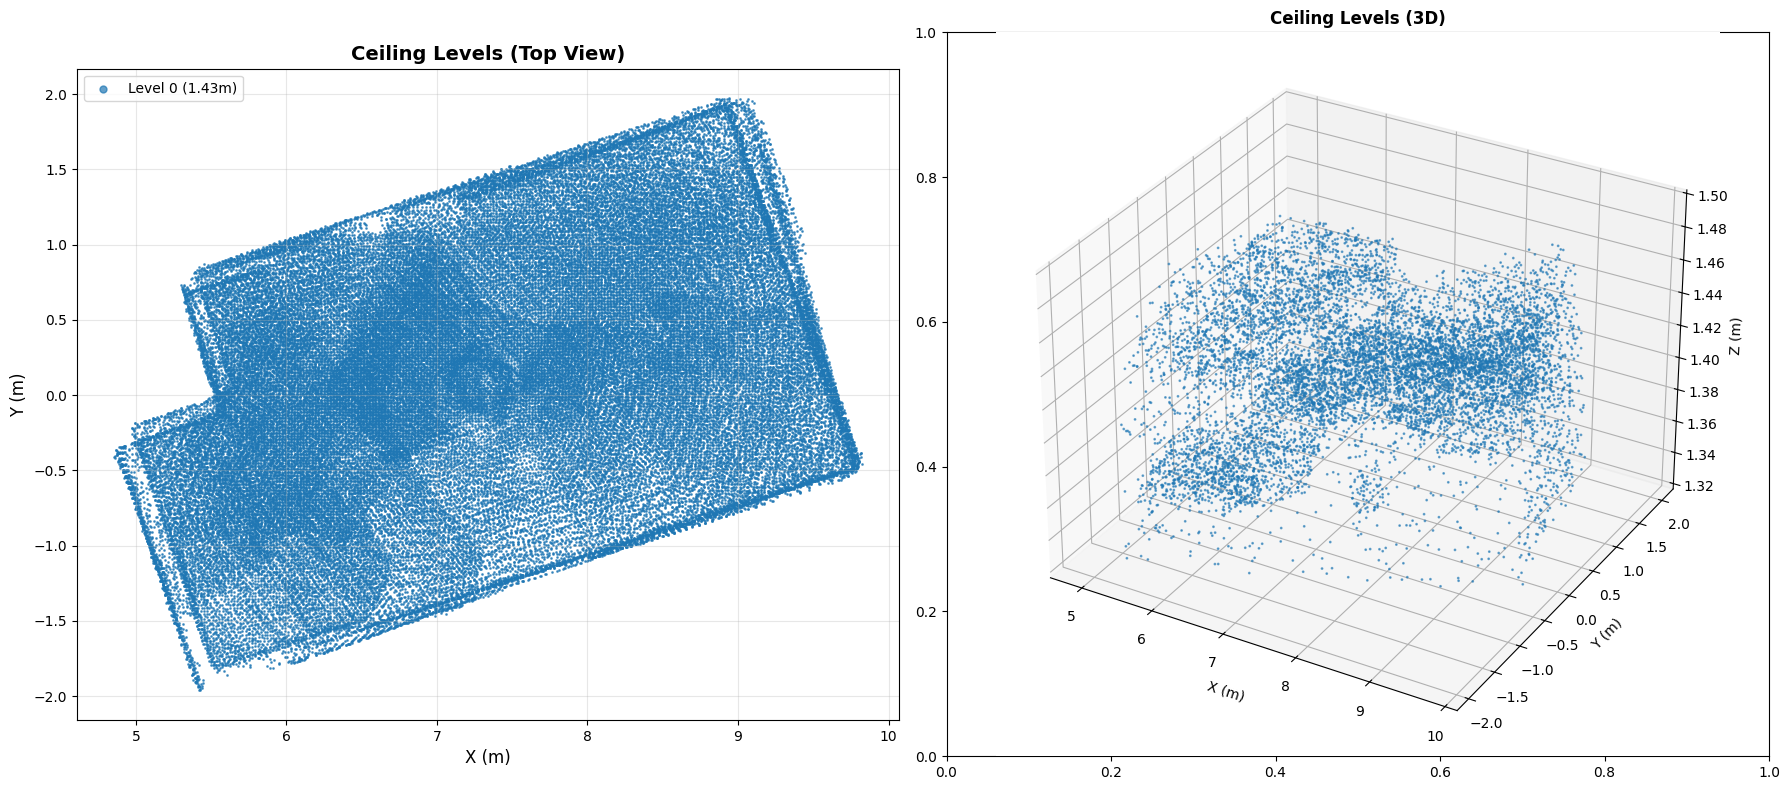


✓ Extracted 1 ceiling level(s)


In [89]:
ceiling_levels = step2_extract_ceiling_levels(
    step1_result,
    selected_peak_ids=[0],
    thickness=0.10
)

In [37]:
remainig_ind = sem_seg.ransac_segmentor.remaining_indices

In [38]:
points = sem_seg.points[remainig_ind]

In [39]:
def extract_wall_points(points, floor_height, ceiling_height, 
                       floor_margin=0.1, ceiling_margin=0.1):
    """
    Keep only points between floor and ceiling (potential walls)
    
    Args:
        points: Nx3 array
        floor_height: float
        ceiling_height: float
        floor_margin: Distance above floor to include (m)
        ceiling_margin: Distance below ceiling to include (m)
    
    Returns:
        wall_points: Filtered points
        wall_mask: Boolean mask
    """
    z_values = points[:, 2]
    
    wall_mask = (z_values > floor_height + floor_margin) & \
                (z_values < ceiling_height - ceiling_margin)
    
    wall_points = points[wall_mask]
    
    print(f"Original points: {len(points)}")
    print(f"Wall points: {len(wall_points)} ({100*len(wall_points)/len(points):.1f}%)")
    
    return wall_points, wall_mask

In [40]:
def visualize_wall_points(wall_points):
    """Visualize extracted wall points"""
    pcd_walls = o3d.geometry.PointCloud()
    pcd_walls.points = o3d.utility.Vector3dVector(wall_points)
    pcd_walls.paint_uniform_color([0, 1, 0])  # Green
    
    o3d.visualization.draw_geometries([pcd_walls], 
                                      window_name="Wall Points (Green)")

In [41]:
floor_h, ceiling_h = sem_seg.ransac_segmentor.get_floor_height(), sem_seg.ransac_segmentor.get_ceiling_height()

In [42]:
floor_h, ceiling_h

(np.float64(-1.2305659184957196), np.float64(1.42436374469335))

In [43]:
wall_points, wall_mask = extract_wall_points(points[:, :3], floor_h, ceiling_h)

Original points: 292592
Wall points: 262650 (89.8%)


In [44]:
visualize_wall_points(wall_points)

In [45]:
def compute_normals(points, radius=0.1, max_nn=30):
    """
    Compute normal vectors for each point
    
    Args:
        points: Nx3 array
        radius: Search radius for normal estimation
        max_nn: Max number of neighbors
    
    Returns:
        normals: Nx3 array of normal vectors
    """
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    
    pcd.estimate_normals(
        search_param=o3d.geometry.KDTreeSearchParamHybrid(
            radius=radius, 
            max_nn=max_nn
        )
    )
    
    # Orient normals consistently (optional but helpful)
    pcd.orient_normals_consistent_tangent_plane(k=15)
    
    normals = np.asarray(pcd.normals)
    
    print(f"Computed normals for {len(normals)} points")
    
    return normals, pcd

In [46]:
def filter_vertical_points(points, normals, vertical_threshold=0.1):
    """
    Keep only points with vertical normals (walls)
    
    Args:
        points: Nx3 array
        normals: Nx3 array
        vertical_threshold: Max abs(normal_z) for vertical surfaces
    
    Returns:
        vertical_points: Filtered points
        vertical_normals: Corresponding normals
        vertical_mask: Boolean mask
    """
    # Vertical surfaces have normals with small Z component
    normal_z = np.abs(normals[:, 2])
    vertical_mask = normal_z < vertical_threshold
    
    vertical_points = points[vertical_mask]
    vertical_normals = normals[vertical_mask]
    
    print(f"Wall points: {len(points)}")
    print(f"Vertical wall points: {len(vertical_points)} "
          f"({100*len(vertical_points)/len(points):.1f}%)")
    
    return vertical_points, vertical_normals, vertical_mask

In [47]:
normals, pcd_with_normals = compute_normals(wall_points)

Computed normals for 262650 points


In [48]:
vertical_points, vertical_normals, vert_mask = filter_vertical_points(
    wall_points, normals
)

Wall points: 262650
Vertical wall points: 151401 (57.6%)


In [49]:
pcd_vert = o3d.geometry.PointCloud()
pcd_vert.points = o3d.utility.Vector3dVector(vertical_points)
pcd_vert.normals = o3d.utility.Vector3dVector(vertical_normals)
pcd_vert.paint_uniform_color([1, 0, 1])  # Magenta
o3d.visualization.draw_geometries([pcd_vert], window_name="Vertical Wall Points")

In [55]:
def detect_walls_per_room_clustered(vertical_points,
                                    floor_height, ceiling_height,
                                    distance_threshold=0.03,
                                    cluster_eps=0.15,
                                    min_cluster_points=100,
                                    min_wall_height=1.5,
                                    min_wall_length=1.0,
                                    max_iterations=30):
    """
    Detect walls using RANSAC + DBSCAN clustering
    
    Process:
    1. RANSAC: Find plane
    2. DBSCAN: Cluster points on that plane (separates disconnected furniture)
    3. Keep largest cluster (main wall segment)
    4. Filter by size
    5. Repeat
    
    Args:
        vertical_points: Nx3 wall points
        point_room_ids: Room ID for each point
        num_rooms: Total rooms
        floor_height, ceiling_height: Room bounds
        distance_threshold: RANSAC plane distance (m)
        cluster_eps: DBSCAN epsilon (m) - distance between points in cluster
        min_cluster_points: Minimum points for valid cluster
        min_wall_height: Minimum wall height (m)
        min_wall_length: Minimum wall length (m)
        max_iterations: Maximum number of planes to detect per room
    
    Returns:
        walls: Dict of room_id -> list of wall info
    """
    walls = {}
    room_height = ceiling_height - floor_height
    
    room_points = vertical_points.copy()
    

    print(f"Total points: {len(room_points)}")
    
    # Storage
    room_walls = []
    remaining_points = room_points.copy()
    
    # Iteratively find planes
    for iteration in range(max_iterations):
        if len(remaining_points) < min_cluster_points:
            print(f"\nStopping: Only {len(remaining_points)} points remaining")
            break
        
        print(f"\n--- Iteration {iteration + 1} ---")
        print(f"Remaining points: {len(remaining_points)}")
        
        # Create point cloud
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(remaining_points)
        
        # STEP 1: RANSAC - Find plane
        plane_model, inliers_idx = pcd.segment_plane(
            distance_threshold=distance_threshold,
            ransac_n=3,
            num_iterations=1000
        )
        
        if len(inliers_idx) < min_cluster_points:
            print(f"Plane too small: {len(inliers_idx)} points")
            break
        
        [a, b, c, d] = plane_model
        print(f"Plane found: {len(inliers_idx)} inliers, normal=[{a:.2f}, {b:.2f}, {c:.2f}]")
        
        # Check verticality
        if abs(c) > 0.3:
            print(f"Not vertical (|normal_z|={abs(c):.2f}), skipping")
            remaining_points = np.delete(remaining_points, inliers_idx, axis=0)
            continue
        
        # Get inlier points
        inlier_points = remaining_points[inliers_idx]
        
        # STEP 2: DBSCAN - Cluster points on this plane
        pcd_inliers = o3d.geometry.PointCloud()
        pcd_inliers.points = o3d.utility.Vector3dVector(inlier_points)
        
        labels = np.array(pcd_inliers.cluster_dbscan(
            eps=cluster_eps,
            min_points=min_cluster_points
        ))
        
        # Find clusters
        unique_labels = np.unique(labels)
        unique_labels = unique_labels[unique_labels >= 0]  # Remove noise (-1)
        
        if len(unique_labels) == 0:
            print("No valid clusters found")
            remaining_points = np.delete(remaining_points, inliers_idx, axis=0)
            continue
        
        # Count points in each cluster
        cluster_sizes = []
        for label in unique_labels:
            cluster_size = np.sum(labels == label)
            cluster_sizes.append(cluster_size)
        
        print(f"Clusters found: {len(unique_labels)}")
        for label, size in zip(unique_labels, cluster_sizes):
            print(f"  Cluster {label}: {size} points")
        
        # STEP 3: Keep largest cluster (main wall segment)
        largest_cluster_idx = unique_labels[np.argmax(cluster_sizes)]
        largest_cluster_size = max(cluster_sizes)
        
        print(f"Largest cluster: {largest_cluster_idx} with {largest_cluster_size} points")
        
        # Extract largest cluster points
        largest_cluster_mask = (labels == largest_cluster_idx)
        wall_segment_points = inlier_points[largest_cluster_mask]
        
        # STEP 4: Validate wall segment
        # Check height
        z_values = wall_segment_points[:, 2]
        wall_height = z_values.max() - z_values.min()
        
        # Check length
        points_2d = wall_segment_points[:, :2]
        
        if len(points_2d) > 2:
            from scipy.spatial import ConvexHull
            try:
                hull = ConvexHull(points_2d)
                perimeter = hull.area
                wall_length = perimeter / 2
                wall_area = wall_length * wall_height
            except:
                wall_length = 0
                wall_area = 0
        else:
            wall_length = 0
            wall_area = 0
        
        # Height ratio
        height_ratio = wall_height / room_height
        
        # Filtering
        is_valid = (
            wall_height >= min_wall_height and
            wall_length >= min_wall_length and
            largest_cluster_size >= min_cluster_points
        )
        
        if not is_valid:
            print(f"❌ Rejected: h={wall_height:.2f}m, len={wall_length:.2f}m, "
                    f"pts={largest_cluster_size}")
            
            # Remove all inliers (including small clusters) from remaining
            remaining_points = np.delete(remaining_points, inliers_idx, axis=0)
            continue
        
        # STEP 5: Store valid wall
        wall_info = {
            'plane_model': plane_model,
            'inliers': wall_segment_points,
            'num_inliers': largest_cluster_size,
            'length': wall_length,
            'height': wall_height,
            'area': wall_area,
            'height_ratio': height_ratio
        }
        
        room_walls.append(wall_info)
        
        print(f"✅ Wall {len(room_walls)}: {largest_cluster_size} points, "
                f"len={wall_length:.2f}m, h={wall_height:.2f}m ({height_ratio*100:.0f}%), "
                f"area={wall_area:.2f}m²")
        
        # Remove ALL inliers (including rejected small clusters)
        remaining_points = np.delete(remaining_points, inliers_idx, axis=0)
    
    return room_walls

In [56]:
walls_clustered = detect_walls_per_room_clustered(
    vertical_points,

    floor_h,
    ceiling_h,
    distance_threshold=0.1,  # Plane fitting tolerance
    cluster_eps=0.12,         # DBSCAN: max distance between points (15cm)
    min_cluster_points=50,   # Minimum points for valid wall segment
    min_wall_height=1.5,      # Minimum 1.5m tall
    min_wall_length=0.5,      # Minimum 1.0m long
    max_iterations=30         # Max walls to detect per room
)

Total points: 151401

--- Iteration 1 ---
Remaining points: 151401
Plane found: 39980 inliers, normal=[-0.31, 0.95, -0.00]
Clusters found: 2
  Cluster 0: 39875 points
  Cluster 1: 55 points
Largest cluster: 0 with 39875 points
✅ Wall 1: 39875 points, len=4.88m, h=2.45m (92%), area=11.97m²

--- Iteration 2 ---
Remaining points: 111421
Plane found: 33426 inliers, normal=[-0.30, 0.95, -0.02]
Clusters found: 1
  Cluster 0: 33422 points
Largest cluster: 0 with 33422 points
✅ Wall 2: 33422 points, len=3.99m, h=2.45m (92%), area=9.78m²

--- Iteration 3 ---
Remaining points: 77995
Plane found: 21872 inliers, normal=[0.96, 0.26, 0.02]
Clusters found: 1
  Cluster 0: 21791 points
Largest cluster: 0 with 21791 points
✅ Wall 3: 21791 points, len=1.87m, h=2.45m (92%), area=4.58m²

--- Iteration 4 ---
Remaining points: 56123
Plane found: 13681 inliers, normal=[-0.31, 0.95, 0.01]
Clusters found: 2
  Cluster 0: 4597 points
  Cluster 1: 9075 points
Largest cluster: 1 with 9075 points
✅ Wall 4: 9075 poin

In [62]:
def get_room_wall_points(walls):
    """
    Extract all wall points for a specific room
    
    Args:
        walls: Dict from detect_walls_per_room_all_clusters
               Format: {room_id: [wall1, wall2, ...]}
               Each wall has: {'inliers': Nx3 array, 'plane_model': [a,b,c,d], ...}
        room_id: Room ID (integer)
    
    Returns:
        points_3d: Nx3 numpy array of all wall points in this room
                   Returns empty array if room not found or has no walls
    """
    
    
    room_walls = walls.copy()
    
    
    # Collect all point clouds from all wall segments
    all_points = []
    
    for i, wall in enumerate(room_walls):
        wall_points = wall['inliers']  # Nx3 array
        all_points.append(wall_points)
    
    # Stack all points into single array
    combined_points = np.vstack(all_points)
    
    
    return combined_points

In [64]:
wall_points = get_room_wall_points(walls_clustered)

In [65]:
def project_points_to_2d(points_3d):
    """
    Project 3D wall points to 2D (X-Y plane)
    
    Args:
        points_3d: Nx3 numpy array (X, Y, Z coordinates)
    
    Returns:
        points_2d: Nx2 numpy array (X, Y coordinates)
    """
    if len(points_3d) == 0:
        return np.array([])
    
    # Simply take X and Y columns (ignore Z)
    points_2d = points_3d[:, :2]
    
    print(f"Projected {len(points_3d)} points to 2D")
    print(f"2D bounds:")
    print(f"  X: [{points_2d[:, 0].min():.3f}, {points_2d[:, 0].max():.3f}] "
          f"(range: {points_2d[:, 0].max() - points_2d[:, 0].min():.3f}m)")
    print(f"  Y: [{points_2d[:, 1].min():.3f}, {points_2d[:, 1].max():.3f}] "
          f"(range: {points_2d[:, 1].max() - points_2d[:, 1].min():.3f}m)")
    
    return points_2d

In [67]:
wall_points_2d = project_points_to_2d(wall_points)

Projected 122367 points to 2D
2D bounds:
  X: [4.866, 9.858] (range: 4.992m)
  Y: [-2.000, 1.969] (range: 3.968m)


In [68]:
def visualize_2d_points(points_2d, title="2D Wall Points", downsample=10):
    """
    Visualize 2D points with matplotlib
    
    Args:
        points_2d: Nx2 numpy array
        title: Plot title
        downsample: Plot every Nth point (for speed with large datasets)
    """
    if len(points_2d) == 0:
        print("No points to visualize")
        return
    
    # Downsample for visualization
    if downsample > 1:
        points_to_plot = points_2d[::downsample]
        print(f"Plotting {len(points_to_plot)} points (downsampled from {len(points_2d)})")
    else:
        points_to_plot = points_2d
    
    plt.figure(figsize=(10, 6))
    plt.scatter(points_to_plot[:, 0], points_to_plot[:, 1], 
                s=1, c='blue', alpha=0.5)
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.title(title)
    plt.axis('equal')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

Plotting 12237 points (downsampled from 122367)


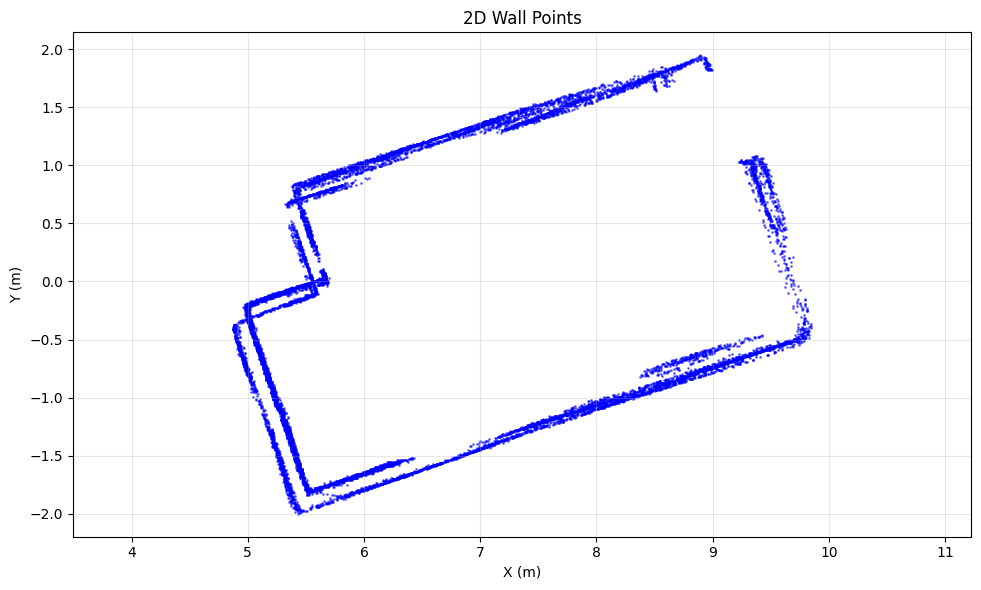

In [71]:
visualize_2d_points(wall_points_2d)

In [74]:
import alphashape

In [75]:
def compute_concave_hull(points_2d, alpha=0.5):
    """
    Compute concave hull (alpha shape) of 2D points
    
    Args:
        points_2d: Nx2 numpy array of 2D points
        alpha: Alpha parameter controlling hull tightness
               - Smaller alpha (0.1-0.3): Tighter, more detailed hull (follows contours closely)
               - Medium alpha (0.5-0.8): Balanced
               - Larger alpha (1.0-2.0): Looser, more convex (smooths over gaps)
               - alpha → infinity: Becomes convex hull
    
    Returns:
        hull_polygon: Shapely Polygon object, or None if failed
    """
    
    print(f"\nComputing concave hull with alpha={alpha}...")
    print(f"Input: {len(points_2d)} points")
    
    try:
        # Compute alpha shape
        hull = alphashape.alphashape(points_2d, alpha)
        
        # Check result type
        if hull is None or hull.is_empty:
            print("Warning: Hull computation returned empty result")
            return None
        
        # Handle MultiPolygon (disconnected regions)
        if hull.geom_type == 'MultiPolygon':
            print(f"Warning: Got MultiPolygon with {len(list(hull.geoms))} parts")
            # Take the largest polygon
            polygons = list(hull.geoms)
            hull = max(polygons, key=lambda p: p.area)
            print(f"Selected largest polygon (area={hull.area:.2f} m²)")
        
        # Get hull info
        num_vertices = len(hull.exterior.coords) - 1  # -1 because first=last
        
        print(f"✓ Hull computed successfully")
        print(f"  Vertices: {num_vertices}")
        print(f"  Area: {hull.area:.2f} m²")
        print(f"  Perimeter: {hull.length:.2f} m")
        
        return hull
    
    except Exception as e:
        print(f"Error computing hull: {e}")
        return None

In [77]:
hull = compute_concave_hull(wall_points_2d)


Computing concave hull with alpha=0.5...
Input: 122367 points
✓ Hull computed successfully
  Vertices: 149
  Area: 12.33 m²
  Perimeter: 14.11 m


In [78]:
def visualize_hull(points_2d, hull_polygon, title="Concave Hull", downsample=10):
    """
    Visualize 2D points with hull overlay
    
    Args:
        points_2d: Nx2 numpy array of original points
        hull_polygon: Shapely Polygon from compute_concave_hull
        title: Plot title
        downsample: Downsample points for faster plotting
    """
    if hull_polygon is None:
        print("No hull to visualize")
        return
    
    # Downsample points
    if downsample > 1:
        points_to_plot = points_2d[::downsample]
    else:
        points_to_plot = points_2d
    
    # Extract hull vertices
    hull_coords = np.array(hull_polygon.exterior.coords)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot points
    ax.scatter(points_to_plot[:, 0], points_to_plot[:, 1], 
               s=1, c='lightblue', alpha=0.3, label='Wall points')
    
    # Plot hull
    ax.plot(hull_coords[:, 0], hull_coords[:, 1], 
            'r-', linewidth=2, label='Concave hull')
    ax.plot(hull_coords[:, 0], hull_coords[:, 1], 
            'ro', markersize=4, label='Hull vertices')
    
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_title(title)
    ax.axis('equal')
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    print(f"\nVisualization info:")
    print(f"  Plotted {len(points_to_plot)} points (downsampled from {len(points_2d)})")
    print(f"  Hull has {len(hull_coords)-1} vertices")

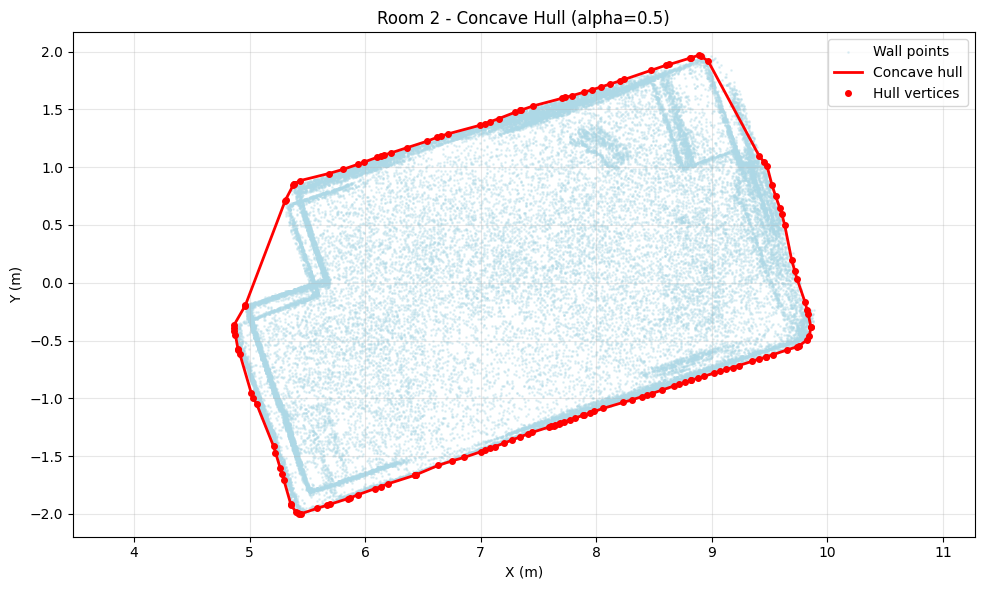


Visualization info:
  Plotted 42699 points (downsampled from 426989)
  Hull has 149 vertices


In [79]:
visualize_hull(points_2d, hull, title="Room 2 - Concave Hull (alpha=0.5)")

In [80]:
def compare_alpha_values(points_2d, alpha_values=[0.3, 0.5, 0.8, 1.0], downsample=10):
    """
    Compare different alpha values side-by-side
    
    Args:
        points_2d: Nx2 numpy array
        alpha_values: List of alpha values to test
        downsample: Downsample for plotting
    """
    
    # Downsample points
    if downsample > 1:
        points_to_plot = points_2d[::downsample]
    else:
        points_to_plot = points_2d
    
    num_alphas = len(alpha_values)
    fig, axes = plt.subplots(1, num_alphas, figsize=(6*num_alphas, 6))
    
    if num_alphas == 1:
        axes = [axes]
    
    for i, alpha in enumerate(alpha_values):
        ax = axes[i]
        
        # Compute hull
        hull = compute_concave_hull(points_2d, alpha=alpha)
        
        if hull is not None:
            # Plot points
            ax.scatter(points_to_plot[:, 0], points_to_plot[:, 1], 
                      s=1, c='lightblue', alpha=0.3)
            
            # Plot hull
            hull_coords = np.array(hull.exterior.coords)
            ax.plot(hull_coords[:, 0], hull_coords[:, 1], 'r-', linewidth=2)
            ax.plot(hull_coords[:, 0], hull_coords[:, 1], 'ro', markersize=3)
            
            ax.set_title(f'Alpha = {alpha}\n{len(hull_coords)-1} vertices, '
                        f'Area = {hull.area:.2f} m²')
        else:
            ax.set_title(f'Alpha = {alpha}\n(failed)')
        
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Y (m)')
        ax.axis('equal')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


Computing concave hull with alpha=0.05...
Input: 122367 points
✓ Hull computed successfully
  Vertices: 51
  Area: 12.42 m²
  Perimeter: 14.10 m


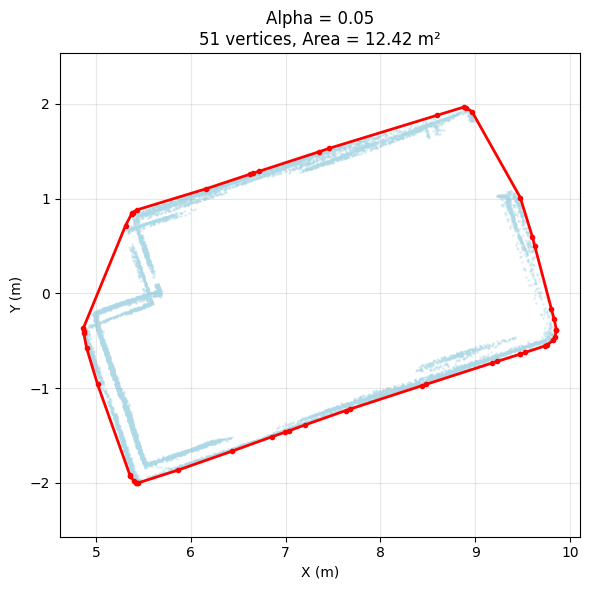

In [83]:
compare_alpha_values(wall_points_2d, alpha_values=[0.05])

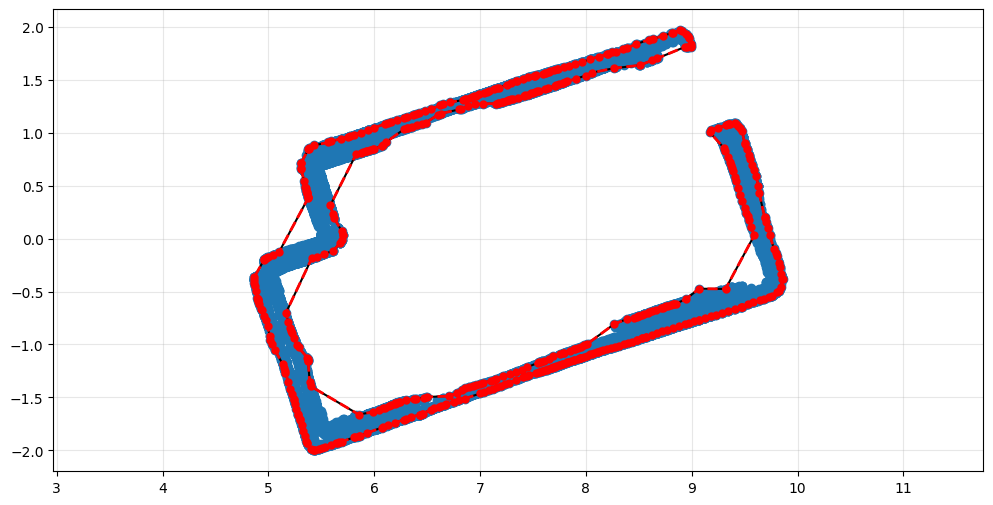

In [99]:
plt.figure(figsize=(12, 6))
plt.plot(wall_points_2d[:, 0], wall_points_2d[:, 1], 'o')

# Get alpha shape
alpha_hull = alpha_shape(wall_points_2d, alpha=0.4)

if alpha_hull.geom_type == 'Polygon':
    x, y = alpha_hull.exterior.xy
    coords = np.array(list(zip(x, y)))
    
    # Plot edges
    for i in range(len(coords) - 1):
        plt.plot([coords[i, 0], coords[i+1, 0]], 
                [coords[i, 1], coords[i+1, 1]], 'k-')
    
    # Plot vertices
    plt.plot(x, y, 'r--', lw=2, marker='o', markersize=5)

plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.show()

In [84]:
def display_inlier_outlier(cloud, ind):
    inlier_cloud = cloud.select_by_index(ind)
    outlier_cloud = cloud.select_by_index(ind, invert=True)

    print("Showing outliers (red) and inliers (gray): ")
    outlier_cloud.paint_uniform_color([1, 0, 0])
    inlier_cloud.paint_uniform_color([0.8, 0.8, 0.8])
    o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud],
                                      zoom=0.3412,
                                      front=[0.4257, -0.2125, -0.8795],
                                      lookat=[2.6172, 2.0475, 1.532],
                                      up=[-0.0694, -0.9768, 0.2024])

In [85]:
voxel_down_pcd = sem_seg.pcd

In [ ]:
(voxel_down_pcd.select_by_index(ind))

PointCloud with 410042 points.

In [91]:
cl, ind = voxel_down_pcd.remove_radius_outlier(nb_points=16, radius=0.05)
display_inlier_outlier(voxel_down_pcd, ind)

Showing outliers (red) and inliers (gray): 


In [94]:
o3d.visualization.draw_geometries([cl])

### pointnet

In [16]:
predictions = sem_seg.pointnet_segmentation(sem_seg.points, type='all')

In [17]:
sem_seg.visualize_segments(predictions)

PointCloud with 891428 points.

In [20]:
sem_seg.classes["ceiling"]

0

In [21]:
ceiling_mask = predictions == sem_seg.classes["ceiling"]
wall_mask = predictions == sem_seg.classes["wall"]
door_mask = predictions == sem_seg.classes["door"]
window_mask = predictions == sem_seg.classes["window"]

ceiling_points_2d = points_2d[ceiling_mask]
wall_points_2d = points_2d[wall_mask]
door_points_2d = points_2d[door_mask]
window_points_2d = points_2d[window_mask]

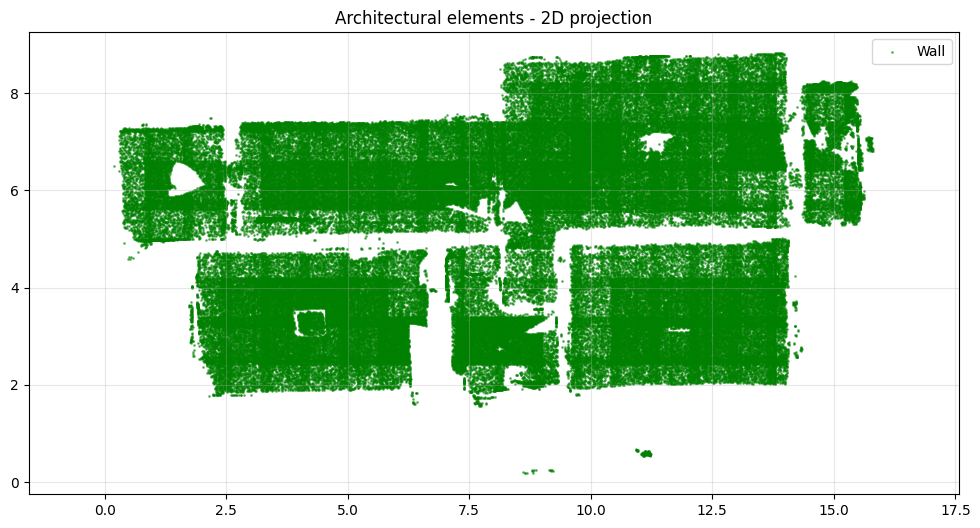

In [23]:
plt.figure(figsize=(12, 6))
plt.scatter(ceiling_points_2d[:, 0], ceiling_points_2d[:, 1], c='green', s=1, label='Wall', alpha=0.5)
# plt.scatter(wall_points_2d[:, 0], wall_points_2d[:, 1], c='gray', s=1, label='Wall', alpha=0.5)
# plt.scatter(window_points_2d[:, 0], window_points_2d[:, 1], c='cyan', s=2, label='Window')
# plt.scatter(door_points_2d[:, 0], door_points_2d[:, 1], c='red', s=2, label='Door')
plt.axis('equal')
plt.legend()
plt.grid(True, alpha=0.3)
plt.title('Architectural elements - 2D projection')
plt.show()

In [116]:
clustering = DBSCAN(eps=0.1, min_samples=5, n_jobs=-1)  
ceiling_clusters = clustering.fit_predict(ceiling_points_2d)

In [121]:
n = len(set(ceiling_clusters)) - (1 if -1 in ceiling_clusters else 0)
print(f"Number of segments found: {n}")

Number of segments found: 16


In [122]:
ceiling_clusters

array([0, 0, 0, ..., 1, 1, 1], shape=(124351,))

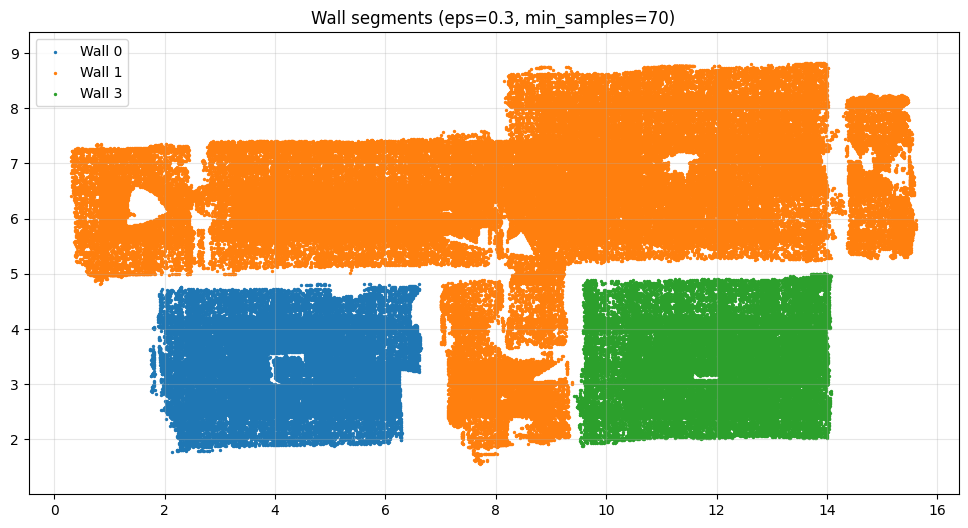

In [133]:
keep_clusters = []
plt.figure(figsize=(12, 6))
for cluster_id in set(ceiling_clusters):
    if cluster_id == -1:
        color = 'black'
        label = 'Noise'
    else:
        label = f'Wall {cluster_id}'
        color = None
    
    mask = ceiling_clusters == cluster_id
    if sum(mask) > 300:
        keep_clusters.append(cluster_id)
        plt.scatter(ceiling_points_2d[mask, 0], ceiling_points_2d[mask, 1], 
                    s=2, label=label, c=color if color else None)

plt.axis('equal')
plt.legend()
plt.title(f'Wall segments (eps=0.3, min_samples=70)')
plt.grid(True, alpha=0.3)
plt.show()

In [134]:
keep_clusters

[np.int64(0), np.int64(1), np.int64(3)]

In [146]:
mask = ceiling_clusters == keep_clusters[0]

In [147]:
sum(mask)

np.int64(22783)

In [148]:
coord = ceiling_points_2d[mask]

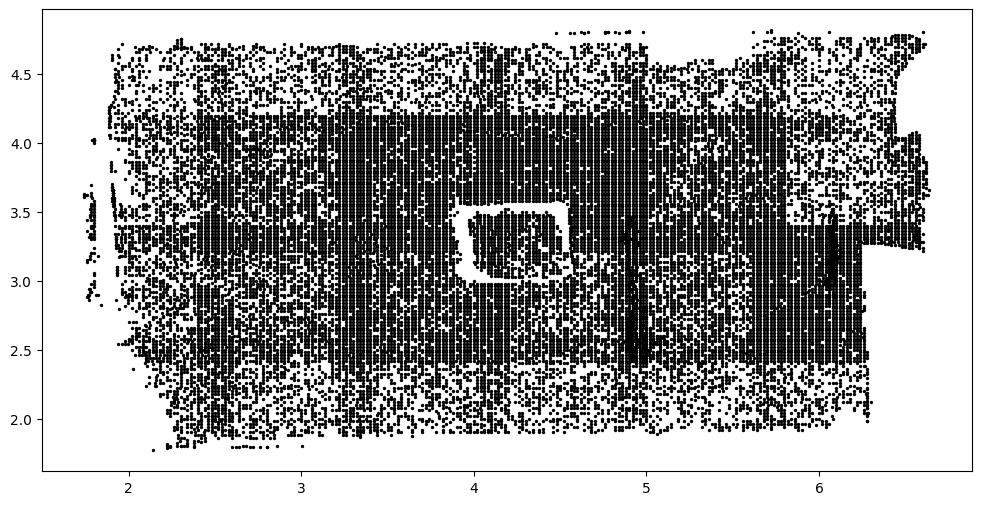

In [149]:
plt.figure(figsize=(12, 6))
plt.scatter(coord[:, 0], coord[:, 1], 
                    s=2, label=label, c=color if color else None)

In [144]:
def get_shape_dimensions_numpy(coordinates_array):
    if coordinates_array.size == 0:
        return 0, 0

    min_coords = np.min(coordinates_array, axis=0)
    max_coords = np.max(coordinates_array, axis=0)

    width = max_coords[0] - min_coords[0]
    height = max_coords[1] - min_coords[1]
    return width, height

In [145]:
get_shape_dimensions_numpy(coord)

(np.float64(4.670390605926514), np.float64(3.1399996876716614))

In [131]:
sum(mask)

np.int64(38)

In [ ]:
wall_indices = sem_seg.ransac_segmentor.segments['wall_pointnet']['indices']
# door_indices = sem_seg.ransac_segmentor.segments['door_pointnet']['indices']
# window_indices = sem_seg.ransac_segmentor.segments['window_pointnet']['indices']

print(f"Wall points: {len(wall_indices)}")
# print(f"Door points: {len(door_indices)}")
# print(f"Window points: {len(window_indices)}")

  

# Extract architectural points using indices
wall_points_2d = points_2d[wall_indices]
# door_points_2d = points_2d[door_indices]
# window_points_2d = points_2d[window_indices]

Wall points: 165476


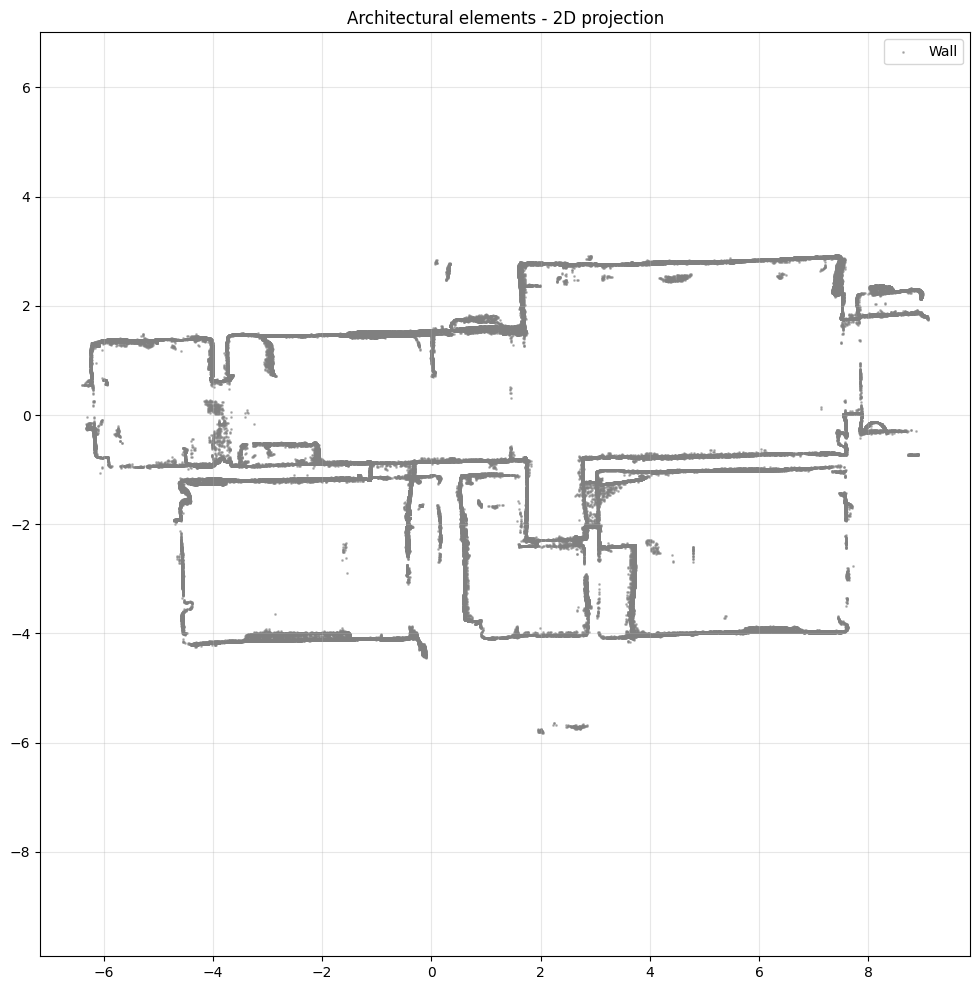

In [13]:
plt.figure(figsize=(12, 12))
plt.scatter(wall_points_2d[:, 0], wall_points_2d[:, 1], c='gray', s=1, label='Wall', alpha=0.5)
# plt.scatter(window_points_2d[:, 0], window_points_2d[:, 1], c='cyan', s=2, label='Window')
# plt.scatter(door_points_2d[:, 0], door_points_2d[:, 1], c='red', s=2, label='Door')
plt.axis('equal')
plt.legend()
plt.grid(True, alpha=0.3)
plt.title('Architectural elements - 2D projection')
plt.show()

In [12]:
door_clusters = sem_seg.ransac_segmentor.cluster_points(door_indices, eps=0.5, )

In [13]:
for i, cluster in enumerate(door_clusters):
    print(i, len(cluster))

0 326
1 15
2 5062
3 12


In [14]:
door_indices_clustered = door_clusters[2]

In [15]:
wall_points_2d = points_2d[wall_indices]
door_points_2d = points_2d[door_indices_clustered]
# window_points_2d = points_2d[window_indices]

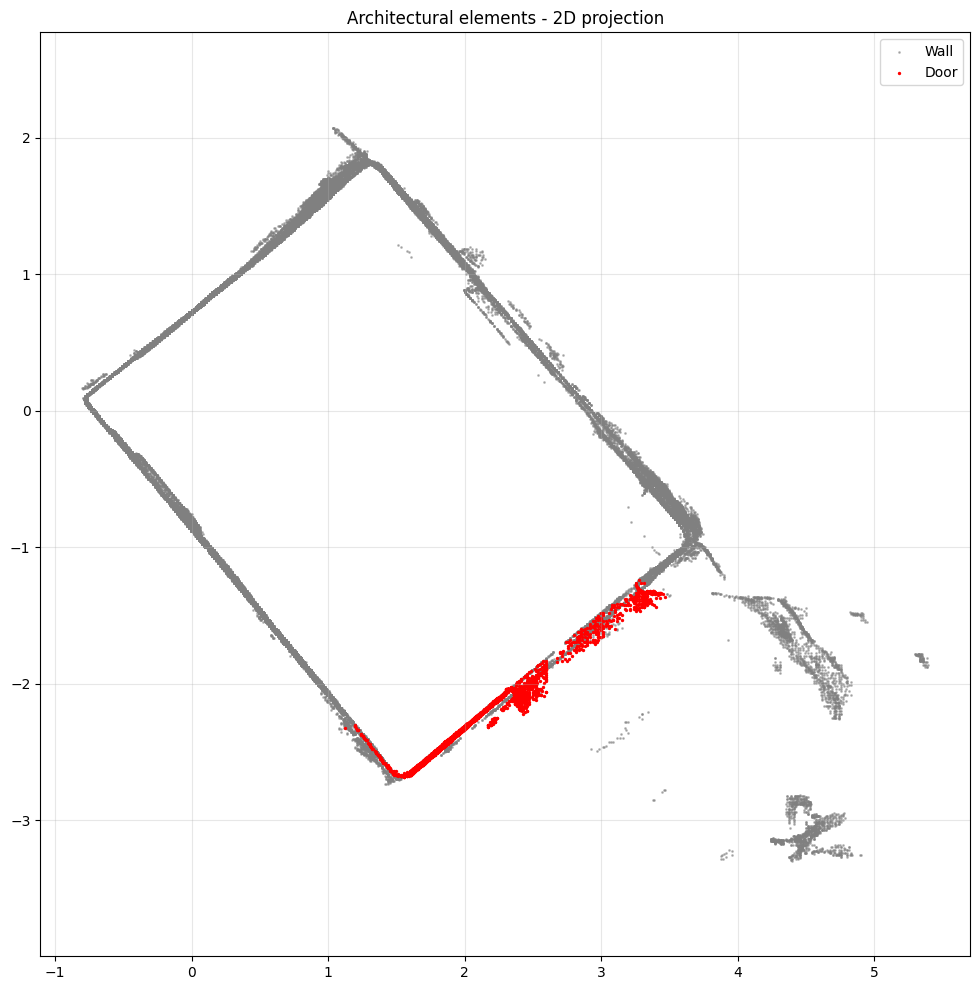

In [16]:
plt.figure(figsize=(12, 12))
plt.scatter(wall_points_2d[:, 0], wall_points_2d[:, 1], c='gray', s=1, label='Wall', alpha=0.5)
# plt.scatter(window_points_2d[:, 0], window_points_2d[:, 1], c='cyan', s=2, label='Window')
plt.scatter(door_points_2d[:, 0], door_points_2d[:, 1], c='red', s=2, label='Door')
plt.axis('equal')
plt.legend()
plt.grid(True, alpha=0.3)
plt.title('Architectural elements - 2D projection')
plt.show()

In [34]:
segment_models = {}
segments_ransac = {}

epsilon = 0.15
min_cluster_points = 50
max_plane_idx = 30
distance_threshold = 0.1
rest = sem_seg.pcd
for i in range(max_plane_idx):
    # colors = plt.get_cmap("tab20")(i)
    segment_models[i], inliers = rest.segment_plane(distance_threshold=distance_threshold, ransac_n=3, num_iterations=2000)
    segments_ransac[i] = rest.select_by_index(inliers)
    labels = np.array(segments_ransac[i].cluster_dbscan(eps=epsilon, min_points=min_cluster_points))
    candidates = [len(np.where(labels == j)[0]) for j in np.unique(labels)]
    best_candidate = int(np.unique(labels)[np.where(candidates == np.max(candidates))[0]])
    rest = rest.select_by_index(inliers, invert=True) + segments_ransac[i].select_by_index(list(np.where(labels != best_candidate)[0]))
    segments_ransac[i] = segments_ransac[i].select_by_index(list(np.where(labels == best_candidate)[0]))
    colors = plt.get_cmap("tab20")(i)
    segments_ransac[i].paint_uniform_color(list(colors[:3]))
    # segments_ransac[i].paint_uniform_color(list(colors[:3]))
    # rest = rest.select_by_index(inliers, invert=True)
    
    # print("pass", i, "/", max_plane_idx, "done.")

/var/folders/j4/yzpk21j93c5bl_mjst9qb4mc0000gn/T/ipykernel_28967/882629629.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  best_candidate = int(np.unique(labels)[np.where(candidates == np.max(candidates))[0]])


In [35]:
o3d.visualization.draw_geometries([segments_ransac[i] for i in range(max_plane_idx)])

In [36]:
sem_seg.visualize_pcd()